In [1]:
import os
import boto3
import pandas as pd
import xgboost as xgb

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sagemaker.experiments import Run, load_run

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


#### Settings

In [2]:
base_dir = '/home/sagemaker-user/sagemaker/01_Iris_simple_e2e' # The base dir on jupyer lab
bucket_name = 'sagemaker-bucket-ds' # Name of the bucket where data and model are stored
project_path_s3 = 'iris_v2' # path to the folder with the project
experiment_name = "iris-v2-experiments" # Name of the experiment

#### Create paths

In [3]:
data_s3_path  = os.path.join('s3://', bucket_name, project_path_s3, 'data') 
bi_s3_path = os.path.join('s3://', bucket_name, project_path_s3, 'batch_inference_input') 

train_s3_path = os.path.join(data_s3_path, 'iris_train.csv')
test_s3_path = os.path.join(data_s3_path, 'iris_test.csv')
infer_s3_path = os.path.join(bi_s3_path, 'iris_infer.csv')
columns_s3_path = os.path.join(data_s3_path, 'iris_column_names.csv')

#### Basic objects

In [4]:
s3 = boto3.client('s3')

#### Read data from S3

In [5]:
# Helper function to read CSV file from S3
def read_csv_from_s3(s3_path):
    bucket, key = s3_path.replace("s3://", "").split("/", 1)
    obj = s3.get_object(Bucket=bucket, Key=key)
    return pd.read_csv(obj['Body'])

# Load column names
column_names_df = read_csv_from_s3(columns_s3_path)
column_names = column_names_df.columns.tolist()

# Load data without headers
df_train = read_csv_from_s3(train_s3_path)
df_train.columns = column_names

df_test = read_csv_from_s3(test_s3_path)
df_test.columns = column_names

df_infer = read_csv_from_s3(infer_s3_path)
df_infer.columns = column_names[1:]

# Display the dataframe
print(df_train.head())
print(df_test.head())
print(df_infer.head())

   class  sepal_length_cm  sepal_width_cm  petal_length_cm  petal_width_cm
0      0              5.1             3.5              1.4             0.3
1      2              5.8             2.7              5.1             1.9
2      1              5.2             2.7              3.9             1.4
3      0              4.6             3.4              1.4             0.3
4      0              5.2             4.1              1.5             0.1
   class  sepal_length_cm  sepal_width_cm  petal_length_cm  petal_width_cm
0      1              6.3             3.3              4.7             1.6
1      0              5.0             3.4              1.5             0.2
2      1              5.8             2.7              4.1             1.0
3      2              7.3             2.9              6.3             1.8
4      1              4.9             2.4              3.3             1.0
   sepal_length_cm  sepal_width_cm  petal_length_cm  petal_width_cm
0              6.3             3

#### Prepare data for XGBoost

In [6]:
# Split the data into features and labels
X_train = df_train.iloc[:, 1:]  # Features
y_train = df_train.iloc[:, 0]   # Labels

X_test = df_test.iloc[:, 1:]  # Features
y_test = df_test.iloc[:, 0]   # Labels

# Convert the datasets into DMatrix, the XGBoost data structure
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dinfer = xgb.DMatrix(df_infer)

#### Train the model

In [7]:
# Set the hyperparameters for the XGBoost model
params = {
    'num_class': 3,
    'max_depth': 3,
    'eta': 0.3,  # Learning rate
    'subsample': 1,  # Subsample ratio of the training instance
    'colsample_bytree': 1,  # Subsample ratio of columns when constructing each tree
    'min_child_weight': 1,  # Minimum sum of instance weight (hessian) needed in a child
    'gamma': 0,  # Minimum loss reduction required to make a further partition on a leaf node
    'lambda': 1,  # L2 regularization term on weights
    'alpha': 0,  # L1 regularization term on weights
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss'
}
num_round = 10


run_name = f"XGboost-trial"
with Run(experiment_name = experiment_name, run_name = run_name) as run:
    # Log parameters
    run.log_parameter("max_depth", params['max_depth'])
    run.log_parameter("eta", params['eta'])
    
    # Train the XGBoost model
    bst = xgb.train(params, dtrain, num_round)

    # Make predictions
    y_pred_prob = bst.predict(dtest)
    y_pred = y_pred_prob.argmax(axis=1)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    
    # Define metrics to log
    run.log_metric(name = "Accuracy", value = accuracy)

INFO:sagemaker.experiments.run:The run (xgboost-trial) under experiment (iris-v2-experiments) already exists. Loading it.


Accuracy: 0.9387755102040817


To view the experiment load Sagemaker Studio Classic and go to Experiment tab
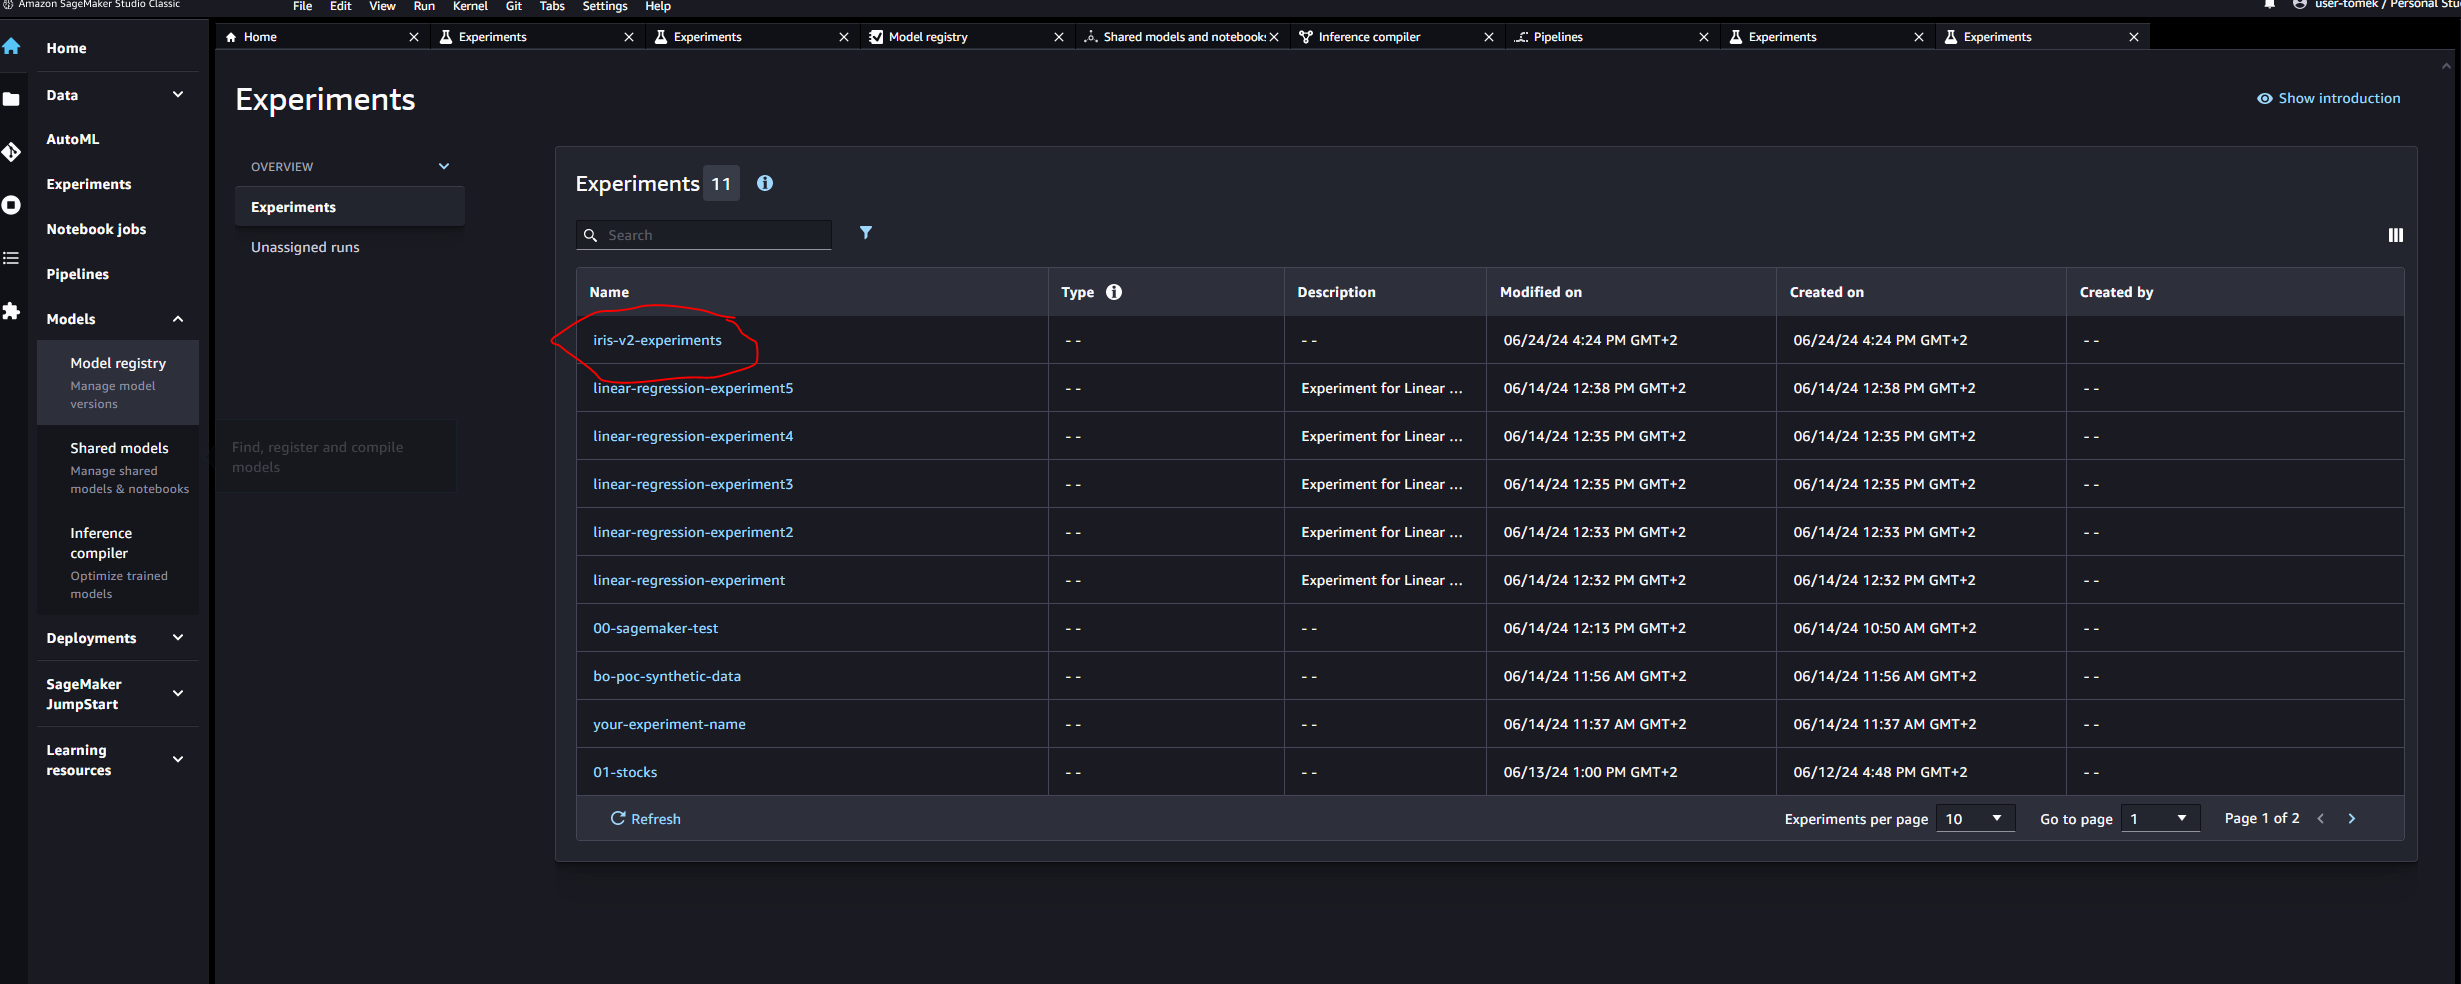

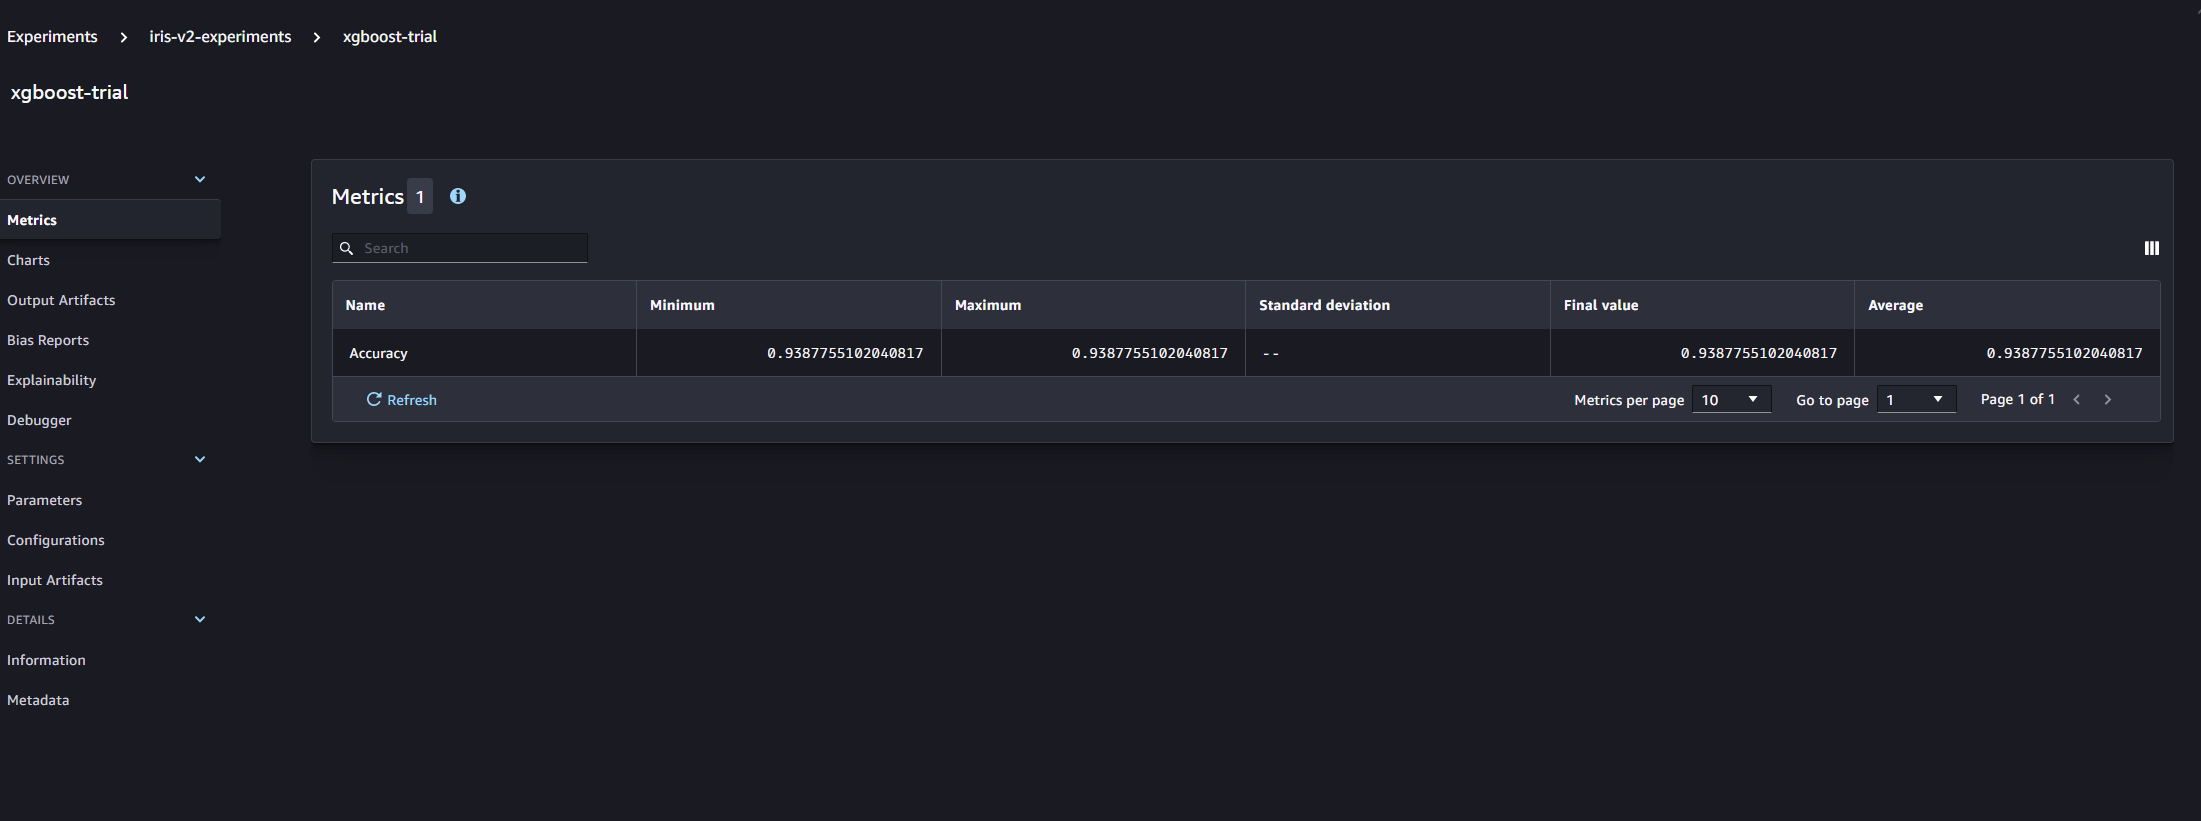

#### Save inference results

In [8]:
y_infer_prob = bst.predict(dinfer)

# Save predictions to a CSV file locally
df_infer_prob = pd.DataFrame(y_infer_prob, columns=['pred_0', 'pred_1', 'pred_2'])
local_predictions_path = os.path.join(base_dir,'data', 'iris_infer_pred_normal.csv')
df_infer_prob.to_csv(local_predictions_path, index=False)

# Upload the CSV file to S3
key_infer_pred = os.path.join(project_path_s3, 'batch_inference_output', 'iris_infer_pred_normal.csv')
s3.upload_file(local_predictions_path, bucket_name, key_infer_pred)

#### Save model

In [9]:
# Save the model to a local file
os.makedirs(os.path.join(base_dir,'model'), exist_ok=True) # Create data folder
local_model_path = os.path.join(base_dir,'model', 'xgboost_normal.json')
bst.save_model(local_model_path)

# Upload the CSV file to S3
key_model = os.path.join(project_path_s3, 'model', 'xgboost_normal.json') 
s3.upload_file(local_model_path, bucket_name, key_model)